# Linearly Decoded Variational Autoencoder (LDVAE)

Here we illustrate the use of the LDVAE using a single-cell RNA-sequencing dataset of peripheral blood mononuclear  cells (PBMC8k) from [Zheng et al. (2017)](https://www.nature.com/articles/ncomms14049). Pre-processing was done in accordance with [Amezquita et al. (2020)](https://bioconductor.org/books/release/OSCA/filtered-human-pbmcs-10x-genomics.html). For more information on LDVAE, see [Svensson et al. (2020)](https://academic.oup.com/bioinformatics/article/36/11/3418/5807606) and [scvi-tools](https://www.scvi-tools.org/).

In [ ]:
# Load Julia packages
using Clustering
using CSV
using Cairo
using Fontconfig
using Gadfly
using MultivariateStats
using DataFrames
using UnicodePlots
using PyCall
using Serialization
using Random
using StatsBase
using Statistics
using TSne
using ColorSchemes
using VegaLite
using Distributions
using Distributed
using LinearAlgebra
using ImageView

In [2]:
# Load Python packages using PyCall
random = pyimport("random");
os = pyimport("os");
np = pyimport("numpy");
pd = pyimport("pandas");
scvi = pyimport("scvi");
scvi_dataset = pyimport("scvi.dataset");
scvi_models = pyimport("scvi.models");
scvi_inference = pyimport("scvi.inference");
torch = pyimport("torch");
scvi_inference_autotune = pyimport("scvi.inference.autotune");
hyperopt = pyimport("hyperopt");

In [3]:
# Set working directory
cd("");

In [4]:
# Read data
countmatrix_tmp = CSV.read("data/PBMC8k_counts.csv");

gene_names = countmatrix_tmp[1:2000,1];

cell_annotation = CSV.read("data/PBMC8k_clust_annotation.csv");
cell_annotation = cell_annotation[:,:x];

x = Array{Float64,2}(Array{Float64,2}(countmatrix_tmp[:,2:end])');

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read(::String) at CSV.jl:46
└ @ CSV /Users/martintreppner/.julia/packages/CSV/UIgP3/src/CSV.jl:46


In [5]:
# Principal component analysis (PCA)

function standardize(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = standardize(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end

pcaout = prcomps(log.(x .+1));

plotdata = DataFrame(PC1 = pcaout[:,1], PC2 = pcaout[:,2], Celltype = cell_annotation);

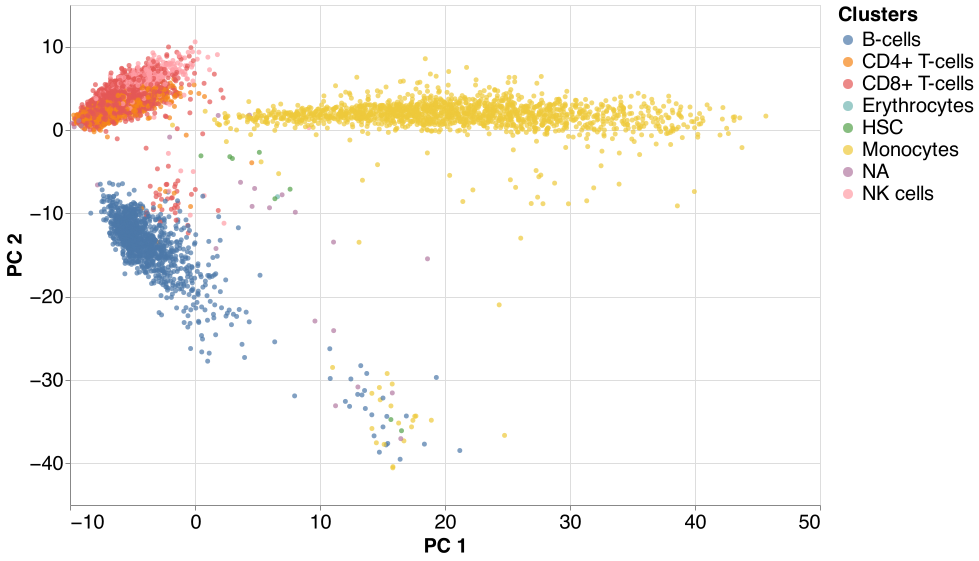

In [6]:
p = plotdata |>
@vlplot(width=750,
        height=500,
        :circle, 
        x={:PC1, title="PC 1", axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
        y={:PC2, title="PC 2", axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
        color={"Celltype:n", legend={disable=false, title="Clusters",orient="right"}},
        size={value=25},
        config={legend={titleFontSize=20, labelFontSize=20}}
)

In [24]:
# LDVAE
data_path = "data/PBMC8k_counts.csv";
n_genes = 2000;
countmatrix = scvi_dataset.CsvDataset(data_path, 
                                save_path = "", 
                                gene_by_cell = true
)

# Set hyperparameters
n_epochs = 250
lr = 0.005
n_latent = 10
n_hidden = 256
n_layers = 2
reconstruction_loss = "nb"
batch_size = 64;
dropout_rate = 0.1;

use_batches = false
use_cuda = true

# Set up LDVAE model
torch.manual_seed(999);
ldvae = scvi_models.LDVAE(
    countmatrix.nb_genes, 
    use_batch_norm=true,
    n_latent=n_latent, 
    latent_distribution = "ln",
    n_hidden=n_hidden,
    dropout_rate=dropout_rate,
    reconstruction_loss=reconstruction_loss, 
);
    
trainer = scvi_inference.UnsupervisedTrainer(ldvae,
    countmatrix,
    frequency=1,
    n_epochs_kl_warmup= 150,
    use_cuda=true
);


[2021-05-13 21:41:59,455] INFO - scvi.dataset.csv | Preprocessing dataset
[2021-05-13 21:42:20,860] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2021-05-13 21:42:21,313] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-05-13 21:42:21,352] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-05-13 21:42:22,802] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-05-13 21:42:22,860] INFO - scvi.dataset.dataset | Downsampled from 7480 to 7480 cells


In [25]:
# Train LDVAE
trainer.train(n_epochs=n_epochs,lr=lr, seed=11);

training: 100%|██████████████████████████████| 250/250 [21:41<00:00,  5.20s/it]

In [26]:
elbo_test = trainer.history["elbo_test_set"][1:end];
elbo_train = trainer.history["elbo_train_set"][1:end];
epochs = collect(1:size(elbo_train,1));

train_dat = DataFrame(hcat(epochs, elbo_train, elbo_test));
rename!(train_dat, :x1 => :epochs, :x2 => :train_set, :x3 => :test_set);
train_dat = stack(train_dat, [:train_set, :test_set]);

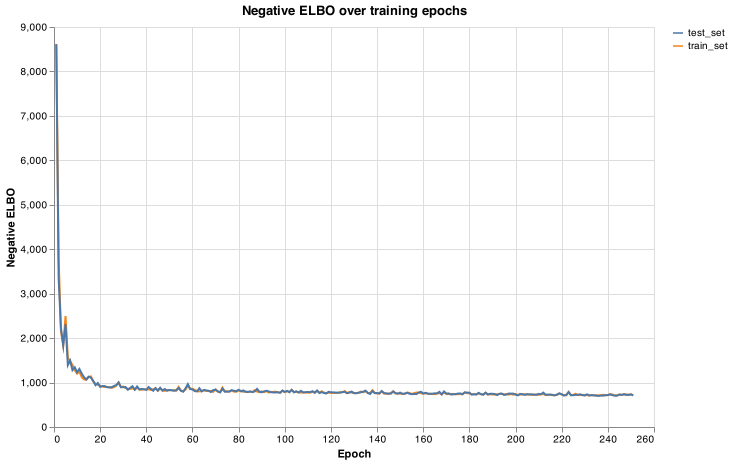

In [27]:
# Show training progress
p1 = train_dat |>
    @vlplot(
        title="Negative ELBO over training epochs",
        width=600, 
        height=400,
        :line,
        x={"epochs:q", title="Epoch"},
        y={"value:q", title="Negative ELBO"},
        color={"variable:n", title=""}
)

In [28]:
# Posterior
torch.manual_seed(59);
full = trainer.create_posterior(trainer.model, trainer.gene_dataset,shuffle=false);
latent, batch_indices, labels = full.get_latent();

In [29]:
# Get loadings
loadings = ldvae.get_loadings();

In [30]:
# Dim 1
i = 1;

# Dim 2
j = 2;

# Determine variance explained by each latent variable
Zcentered = latent .- mapslices(mean,latent,dims=2);
Zscaled = latent ./ mapslices(std,latent,dims=2);
ZTZ = cov(Zscaled',dims=2);
    
eigen_values = eigvals(ZTZ);
singular_values = sqrt.(eigen_values);

variance_explained = singular_values ./ sum(singular_values);

idx = sortperm(variance_explained, rev=true);

latent_ordered = latent;
loadings_ordered = loadings;

w_columns = [Symbol(string("x$i")), Symbol(string("x$j"))];

latent_plot = DataFrame(hcat(String.(cell_annotation),latent_ordered));
rename!(latent_plot, :x1 => :celltype, :x2 => :x1, :x3 => :x2, :x4 => :x3, :x5 => :x4, :x6 => :x5, :x7 => :x6, :x8 => :x7, :x9 => :x8, :x10 => :x9, :x11 => :x10);
loadings_plot = DataFrame(hcat(gene_names,loadings_ordered));
rename!(loadings_plot, :x1 => :Gene, :x2 => :x1, :x3 => :x2, :x4 => :x3, :x5 => :x4, :x6 => :x5, :x7 => :x6, :x8 => :x7, :x9 => :x8, :x10 => :x9, :x11 => :x10);

tmp_w_ordered = DataFrame(deepcopy(loadings_plot));
tmp_w_ordered[:lnth] = mapslices(LinearAlgebra.norm, Array{Float64,2}(tmp_w_ordered[:,w_columns]), dims=2)[:,1];

number_of_genes = 2000;
ggg = sort(tmp_w_ordered, :lnth, rev=true);
ggg_plot = ggg[1:number_of_genes,[:Gene, w_columns[1], w_columns[2], :lnth]];
ggg_plot[:origin1] = 0.0;
ggg_plot[:origin2] = 0.0;

ggg_plot = filter(row -> row.Gene == "S100A8" || row.Gene == "S100A9" || row.Gene == "CD79A" || row.Gene == "CD79B" || row.Gene == "NKG7" || row.Gene == "GNLY", ggg_plot);

var_exp_1 = round(Array{Float64,1}(variance_explained[idx])[1] * 100, digits=2);
var_exp_2 = round(Array{Float64,1}(variance_explained[idx])[2] * 100, digits=2);

In [31]:
# Plotting
seaborn = pyimport("seaborn");
plt = pyimport("matplotlib");

# Data prep latents
tmp = hcat(String.(cell_annotation), latent);
latent_plot_latent = pd.DataFrame(data=tmp, columns= ["celltype","Z 1","Z 2","Z 3","Z 4","Z 5","Z 6","Z 7","Z 8","Z 9","Z 10"]);

tmp1 = vcat(tmp[tmp[:,1] .== "Monocytes",:], tmp[tmp[:,1] .== "B-cells",:], tmp[tmp[:,1] .== "NK cells",:]);
latent_plot_filtered = pd.DataFrame(data=tmp1, columns= ["celltype","Z 1","Z 2","Z 3","Z 4","Z 5","Z 6","Z 7","Z 8","Z 9","Z 10"]);

In [32]:
# Scatterplot with kde overlayed for latents
g = seaborn.set_context("notebook", font_scale=1.5);
g = seaborn.relplot(x="Z $i", y="Z $j", data=latent_plot_latent, color="grey", alpha=0.5);
g = seaborn.kdeplot(x="Z $i", y="Z $j", hue="celltype", data=latent_plot_filtered, palette="tab10", legend = true);
plt.pyplot.savefig("fig_latent.png")
plt.pyplot.clf()

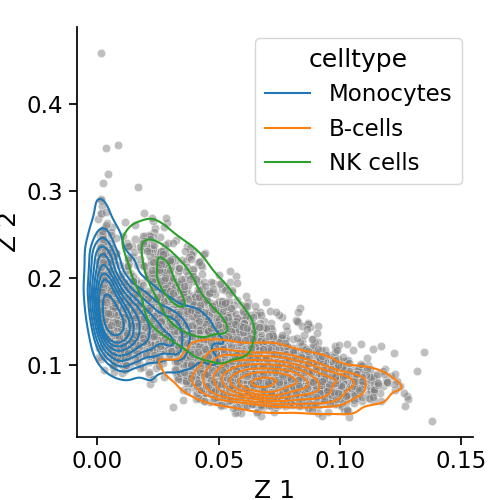

In [33]:
fig_latent = load("fig_latent.png")

After plotting the first to latent variables of the linearly decoded variational autoencoder, we can see that these latent variables learned to distinguish between monocytes, b-cells, and nk cells.

In [34]:
# Data prep loadings
tmp = hcat(String.(gene_names), loadings_ordered);
loadings_plot_loadings = pd.DataFrame(data=tmp, columns= ["Gene","W 1","W 2","W 3","W 4","W 5","W 6","W 7","W 8","W 9","W 10"]);

tmp1 = Array{Any,2}(ggg_plot);
loadings_plot_genes = pd.DataFrame(data=tmp1, columns= ["Gene","W_$i", "W_$j", "lnth", "origin1", "origin2"]);

In [35]:
# Scatterplot with loadings
g = seaborn.set_context("notebook", font_scale=1.5)
g = seaborn.relplot(x="W $i", y="W $j", data=loadings_plot_loadings, color="grey", alpha=0.5)
for k in 1:size(ggg_plot,1)
    plt.pyplot.text(loadings_plot_genes["W_$i"][k], loadings_plot_genes["W_$j"][k], loadings_plot_genes.Gene[k], horizontalalignment="left", size="medium", color="black", weight="semibold")
    plt.pyplot.plot([0, loadings_plot_genes["W_$i"][k]], [0, loadings_plot_genes["W_$j"][k]], linewidth=1, color="black")
end
plt.pyplot.savefig("fig_loadings.png")
plt.pyplot.clf()

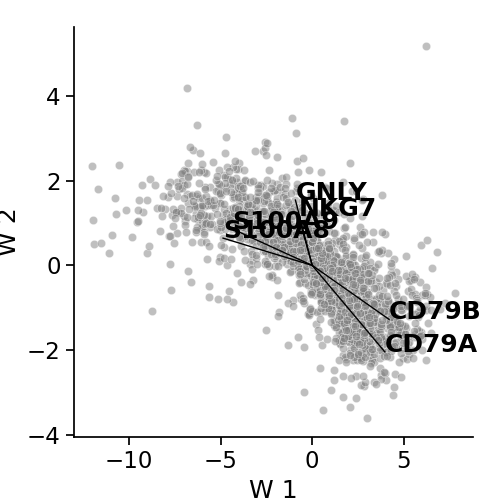

In [36]:
fig_loadings = load("fig_loadings.png")

When plotting the corresponding loadings of the linear factor models, we find marker genes for each of the respective cell types among the features with the highest weights. Here, S100A8 and S100A9 mark monocytes, GNLY and NKH7 mark natural killer cells, and CD79A and CD79B mark B-cells.

In [37]:
# Generate synthetic data
Random.seed!(111);
gen_data_ldvae = full.generate();
syn_dat = gen_data_ldvae[1][:,:,1];

In [38]:
gene_name = ["LYZ", "IGKC", "GNLY"];
gene1 = findall(gene_names .== [gene_name[1]]);
gene2 = findall(gene_names .== [gene_name[2]]);
gene3 = findall(gene_names .== [gene_name[3]]);

type_syn = repeat(["Synthetic"], size(syn_dat,1));
type_orig = repeat(["Original"], size(syn_dat,1));

tmp = vcat(hcat(log.(syn_dat[:, gene1] .+ 1), type_syn, repeat([gene_name[1]], size(syn_dat,1))), hcat(log.(syn_dat[:, gene2] .+ 1), type_syn, repeat([gene_name[2]], size(syn_dat,1))),
hcat(log.(syn_dat[:, gene3] .+ 1), type_syn, repeat([gene_name[3]], size(syn_dat,1))),
hcat(log.(x[:, gene1] .+ 1), type_orig, repeat([gene_name[1]], size(syn_dat,1))), hcat(log.(x[:, gene2] .+ 1), type_orig, repeat([gene_name[2]], size(syn_dat,1))),
hcat(log.(x[:, gene3] .+ 1), type_orig, repeat([gene_name[3]], size(syn_dat,1))));

bimod_dat = pd.DataFrame(data=tmp, columns= ["log(UMI + 1)","Type","Gene"]);

In [39]:
k = seaborn.violinplot(data=bimod_dat, x="log(UMI + 1)", y="Gene", hue="Type", 
                        split=true, inner=nothing, bw = 0.65, linewidth=1, palette="tab10", 
                        cut=0.0, scale="area", orient="h", width=1.0)
k = seaborn.despine(left=true)
plt.pyplot.savefig("fig_genes.png")
plt.pyplot.clf()

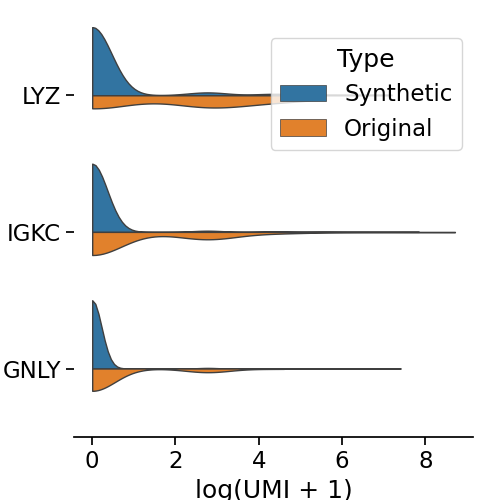

In [40]:
fig_loadings = load("fig_genes.png")

We generated synthetic data using the LDVAE and compare the learned distribution for some exemplary genes. We can see that in some scenarios, LDVAE has difficulties in learning bimodality.